# Advanced Methods for Driving your Network with Synapic Spike-trains

BMTK is designed to build and simulate large-scale, realistic models of the nervous system. Most of these realistic simulations require the ability to recreate the kinds of synaptic input you would expect to see in vivo. To achieve this, modelers need to be able to generate the relevant spike trains that drive the synaptic stimuli of our simulations.

We have other tutorials demonstrating how to generate realistic stimuli using [FilterNet](). We have also shown how to use the BMTK [SpikeTrain]() and [PoissonSpikeTrain]() classes to generate input spike trains. In these cases, users must generate SONATA spike-train files before running their simulations. However, BMTK has additional methods for users to generate and import spike-train stimuli into their simulations. It includes using other formats besides SONATA, importing experimental data, and more fine-grained control of how and where cells within a network receive synaptic stimuli.

We will cover some of such methods in this tutorial.

**Note** - scripts and files for running this tutorial can be found in the directory [03_opt_advanced_spiking_inputs/](https://github.com/AllenInstitute/bmtk/tree/develop/docs/tutorial/03_opt_advanced_spiking_inputs)

---

## Contents
1. [Example: Spike-train inputs from a custom created csv file](#example-spikes-from-csv)
2. [Example: Dynamically generating spike-trains with cusom function](#example-spikes-from-func)
3. [Example: Incorporating in-vivo NWB spiking data into your simulation](#example-spikes-from-nwb)
4. [Example: Forcing spotonaneous synaptic activity within a network](#example-spikes-from-spont)

---

## 1. Example: Using spikes from CSV <a class="anchor" id="example-spikes-from-csv">

In [Tutorial 2](https://github.com/AllenInstitute/bmtk/blob/develop/docs/tutorial/02_single_cell_syn.ipynb), we demonstrated how to generate network spikes using the BMTK's built-in PoissonSpikeGenerator class, which will produce a series of spike trains using the distribution parameters/functions we give it and save it to a SONATA spikes file using to `to_sonata` method. But BMTK also allows input spikes to be saved and loaded using a simpler space-separated CSV file, which, in many cases, can be easier to analyze and use with other programs.

For example, in the **network_simple_spikes/** folder (built using `build_network.simple_spikes.py`), we have a set of 10 virtual nodes that synaptically drive our simulation. If we want each one to fire at a constant 10Hz firing rate over a 5-second interval, we can use PoissonSpikeGenerator's `to_csv()` class to save the spikes as a CSV file.

In [1]:
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

psg = PoissonSpikeGenerator()
psg.add(
    node_ids='network_csv_spikes/inputs_nodes.h5', 
    firing_rate=10.0, 
    times=(0.0, 5.0),
    population='inputs'
)
psg.to_csv('inputs/simple_spikes.csv')

Now, we can use any text editor or CSV reader (like pandas) to read in our spikes for verification and analysis.

In [2]:
import pandas as pd

spikes_inputs = pd.read_csv('inputs/simple_spikes.csv', sep=' ')

# Let's quickly check that our csv file makes sense
n_nodes = spikes_inputs['node_ids'].unique().shape[0]
n_spikes = spikes_inputs.shape[0]

print(f'Number of cells in spikes-file: {n_nodes} (expected: 5)')
print(f'Avg. number of spikes per cell: {n_spikes/n_nodes} (expected: 5sec x 10Hz ~ 50)')
print(f'Min spike-time: {spikes_inputs["timestamps"].min()} ms')
print(f'Max spike-time: {spikes_inputs["timestamps"].max()} ms')

spikes_inputs.head()

Number of cells in spikes-file: 10 (expected: 5)
Avg. number of spikes per cell: 50.1 (expected: 5sec x 10Hz ~ 50)
Min spike-time: 17.593944539645307 ms
Max spike-time: 4998.560456807771 ms


,timestamps,population,node_ids
0,40.425085,inputs,0
1,326.168408,inputs,0
2,434.783000,inputs,0
3,821.277923,inputs,0
4,847.735538,inputs,0


Then, when running the simulation, we can do so as we previously did with SONATA spike files, but the difference is that the **module** type for the given input must be changed from `sonata` to `csv`:

```json
  "inputs": {
    "csv_spikes": {
      "input_type": "spikes",
      "module": "csv",
      "input_file": "./inputs/simple_spikes.csv",
      "node_set": "inputs"
    }
  },

### Creating your own csv file

You can create your own spike-train CSV file if you don't want to use the `PoissonSpikeGenerator` class. As we can see from above, it needs to be a space-separated text file with columns **timestamps**, **population**, and **node_ids** (order doesn't matter). Each row indicates a separate spike, with the **population** + **node_ids** columns indicating the node/cell that fired and **timestamps** (in milliseconds) indicating when it fired.

For example, we can use the Python CSV writer class to create an example input file where each cell has an increasing firing rate.

In [3]:
import csv
import numpy as np

with open('inputs/custom_spikes.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=' ', quotechar='#')

    # write the header
    csvwriter.writerow(['timestamps', 'population', 'node_ids'])
    
    # For node 0 we have it fire randomly at 1 Hz for 5 seconds, for node 1 at 2Hz, etc.
    for node_id in range(10):
        for timestamp in np.sort(np.random.uniform(0.0, 5000.0, size=(node_id+1)*5)):
            csvwriter.writerow([timestamp, 'inputs', node_id])

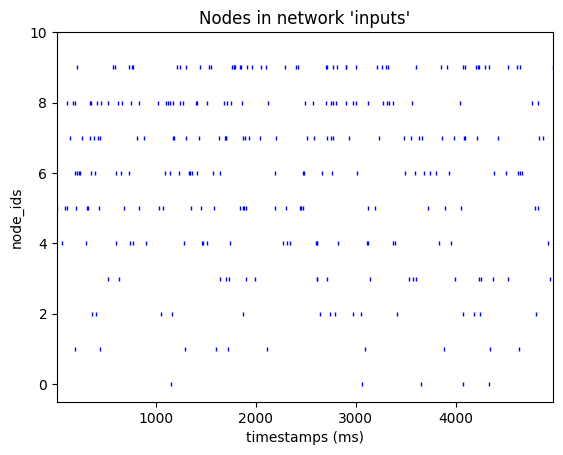

In [4]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(spikes_file='inputs/custom_spikes.csv', with_histogram=False)

**Remember**: Biophysical models contain customized ion channels that require compiling using the `nrnivmod` command before running Bionet (see [Tutorial 1](https://github.com/AllenInstitute/bmtk/blob/develop/docs/tutorial/01_single_cell_clamped.ipynb) for more details). Ion channels are stored in the **components/mechanisms/mod/** folder. In a shell or using Jupyter notebook, you'll need to run the following:

In [5]:
! cd components/mechanisms && nrnivmodl modfiles

/opt/conda/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/shared/bmtk-workshop/docs/tutorial/03_opt_advanced_spiking_inputs/components/mechanisms
Mod files: "modfiles/modfiles/CaDynamics.mod" "modfiles/modfiles/Ca_HVA.mod" "modfiles/modfiles/Ca_LVA.mod" "modfiles/modfiles/Ih.mod" "modfiles/modfiles/Im.mod" "modfiles/modfiles/Im_v2.mod" "modfiles/modfiles/K_P.mod" "modfiles/modfiles/K_T.mod" "modfiles/modfiles/Kd.mod" "modfiles/modfiles/Kv2like.mod" "modfiles/modfiles/Kv3_1.mod" "modfiles/modfiles/NaTa.mod" "modfiles/modfiles/NaTs.mod" "modfiles/modfiles/NaV.mod" "modfiles/modfiles/Nap.mod" "modfiles/modfiles/SK.mod" "modfiles/modfiles/exp1isyn.mod" "modfiles/modfiles/exp1syn.mod" "modfiles/modfiles/stp1syn.mod" "modfiles/modfiles/stp2syn.mod" "modfiles/modfiles/stp3syn.mod" "modfiles/modfiles/stp4syn.mod" "modfiles/modfiles/stp5isyn.mod" "modfiles/modf

We can now run the simulation with our custom CSV input file.

2024-10-24 00:02:57,330 [INFO] Created log file
2024-10-24 00:02:57,418 [INFO] Building cells.


--No graphics will be displayed.


2024-10-24 00:02:58,097 [INFO] Building recurrent connections
2024-10-24 00:02:58,102 [INFO] Building virtual cell stimulations for LGN_spikes_sonata
2024-10-24 00:02:58,137 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-10-24 00:02:58,138 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-10-24 00:02:58,138 [INFO] Block save every 5000 steps
2024-10-24 00:02:58,492 [INFO]     step:5000 t_sim:500.00 ms
2024-10-24 00:02:58,839 [INFO]     step:10000 t_sim:1000.00 ms
2024-10-24 00:02:59,176 [INFO]     step:15000 t_sim:1500.00 ms
2024-10-24 00:02:59,514 [INFO]     step:20000 t_sim:2000.00 ms
2024-10-24 00:02:59,549 [INFO] Simulation completed in 1.412 seconds 


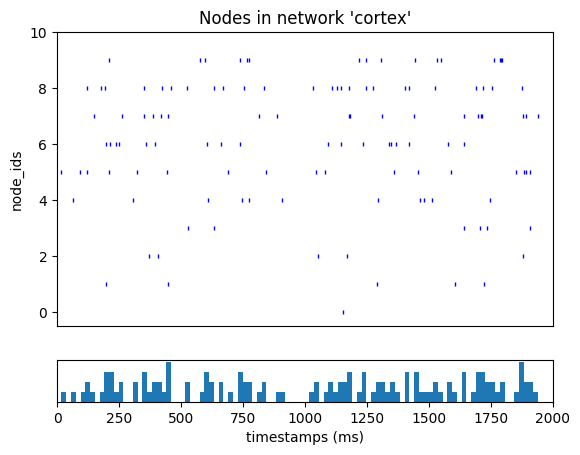

In [6]:
from bmtk.simulator import bionet
from bmtk.analyzer.spike_trains import plot_raster, to_dataframe

bionet.reset()
conf = bionet.Config.from_json('config.csv_spikes.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

_ = plot_raster(config_file='config.csv_spikes.json')

## 2. Example: Dynamically generating custom spike-trains <a class="anchor" id="example-spikes-from-func">

Pregenerating spike trains for your simulations inside an hdf5 or CSV file is computationally efficient and makes your results more accessible to reproduce and share. However, at times, it may be beneficial for users to generate spike trains dynamically during each simulation. If you are doing quick simulations and spot-checks, it can be cumbersome having to regenerate a file beforehand. Or if a user is running thousands of simulations or doing some kind of gradient search, the cost of potentially creating thousands of spike files beforehand may not be reasonable.

BMTK also allows modelers to create their own special function, which will generate new spike trains at the start of each simulation. To do so, you only need to make changes to the configuration for a "spikes" input so that the **module** is set to value `function`, and instead of spikes_input, you specify a **spikes_function** parameter that will be the name of your custom function.

```json
"inputs": {
    "LGN_spikes_sonata": {
        "input_type": "spikes",
        "module": "function",
        "spikes_function": "my_spikes_generator",
        "node_set": "LGN"
    }
}
```

For BMTK to know where to find the `my_spikes_generator`, you must then use the `@spikes_generator` at the top of a given function in your run_bmtk.py script (or any python file imported into the run script). In the below example, we use the following to return spike trains for every cell in the `LGN` node_set to fire at a constant rate (although different rates for different models).

In [7]:
from bmtk.simulator.bionet.io_tools import io
from bmtk.simulator.bionet import spikes_generator
import numpy as np

@spikes_generator
def my_spikes_generator(node, sim):
    io.log_info(f'Generating custom spike trains for {node.node_id} from {node.population_name}')
    if node['pop_name'] == 'tON':
        return np.arange(100.0, sim.tstop, step=sim.dt*10)
    elif node['pop_name'] == 'tOFF':
        return np.arange(100.0, sim.tstop, step=sim.dt*20)
    else:
        return []


* All `spikes_generator` functions must have parameters `node` and `sim`.
  * `node` allows you to access information about each node/cell like a dictionary.
  * `sim` is a class containing information about a current simulation, including information like start time (`sim.tstart`), stop_time (`sim.tstop`), step size (`sim.dt`), among other properties.
* The `spikes_generator` should return either a list or array of timestamps, in milliseconds, for each node.
* We include a logging statement for good measure. This is not required, but it is good for debugging and checking that our custom function is being called.

When the simulation is running, the `my_spikes_generator` function will be called once for each node in the specified **node_set**. 

In [8]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.spikes_generator.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2024-10-24 00:02:59,673 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-10-24 00:02:59,707 [INFO] Building cells.
2024-10-24 00:03:06,517 [INFO] Building recurrent connections
2024-10-24 00:03:06,532 [INFO] Building virtual cell stimulations for LGN_spikes_sonata
2024-10-24 00:03:06,545 [INFO] Generating custom spike trains for 0 from LGN
2024-10-24 00:03:06,549 [INFO] Generating custom spike trains for 28 from LGN
2024-10-24 00:03:06,550 [INFO] Generating custom spike trains for 27 from LGN
2024-10-24 00:03:06,551 [INFO] Generating custom spike trains for 14 from LGN
2024-10-24 00:03:06,552 [INFO] Generating custom spike trains for 2 from LGN
2024-10-24 00:03:06,553 [INFO] Generating custom spike trains for 38 from LGN
2024-10-24 00:03:06,554 [INFO] Generating custom spike trains for 26 from LGN
2024-10-24 00:03:06,555 [INFO] Generating custom spike trains for 15 from LGN
2024-10-24 00:03:06,556 [INFO] Generating custom spike train

## 3. Example: Incorporating real data with NWB <a class="anchor" id="example-spikes-from-nwb">

You can use tools like FilterNet or PoissonSpikeGenerator to create theoretical-to-realistic synaptic stimuli onto a network from various modes. But better yet, when actual experimental data is available, it is often possible to just use that. Especially as more and more experimental electrophysiological data sets are being made publically available through resources like [DANDI](https://dandiarchive.org/) or [The Allen Brain Observatory](https://portal.brain-map.org/circuits-behavior/visual-coding-neuropixels), we will want not only to use such data as a base-line for validating and comparing our models but to actually use the data within specific simulations. For example, when modeling a network of one population and/or region, we will want to use recordings of surrounding cells to help excite and inhibit our cells more realistically.

Traditionally a major issue with using encorporating experimental ephys data into simulations is trying to parse the wide variety of different ways the data was stored. Luckily, the [Neurodata Without Borders (NWB)](https://www.nwb.org/) has developed a field-adopted format for storing experimental data. BMTK can take these files and automatically insert them into simulations.

In this example, we will take the previous model of the Mouse Primary Visual Cortex and add inputs that we know come from higher cortical regions (in this case, just the VisL and Hippocampal regions) along with the input from the LGN. For these added regions, we will use actual neuropixel recordings of activity from the region during drifting gratings.

### Step 1: Download the data

The first step is to find experimental NWB that includes spiking events. For our example, we will use data from Allen Institute Visual Coding Data downloaded using the AllenSDK. We will get three experimental sessions that we know contain recordings of the VisL and hippocampus.

In [1]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

cache = EcephysProjectCache.from_warehouse(
    manifest='./ecephys_cache_dir/neuropixels.manifest.json'
)
cache.get_session_data(715093703)
cache.get_session_data(798911424)
cache.get_session_data(754829445)

Downloading:   0%|          | 0.00/2.86G [00:00<?, ?B/s]

/opt/anaconda3/envs/biorealistic-v1/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/anaconda3/envs/biorealistic-v1/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Downloading:   0%|          | 0.00/2.86G [00:00<?, ?B/s]

/opt/anaconda3/envs/biorealistic-v1/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/anaconda3/envs/biorealistic-v1/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


Downloading:   0%|          | 0.00/2.70G [00:00<?, ?B/s]

/opt/anaconda3/envs/biorealistic-v1/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/opt/anaconda3/envs/biorealistic-v1/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


By default, the NWB files will be downloaded into the *ecephys_cache_dir*. Since nwb files are essentially just structured HDF5 files, you can use tools like [HDFView](https://www.hdfgroup.org/downloads/hdfview/) or [h5py](https://www.h5py.org/) to read them once they have been downloaded. 

### Step 2: Connecting VISL and Hippocampal onto our V1 cells.

To simulate synaptic stimulation from the VisL and Hippocampal cell recordings onto our V1 model, we will need to create a population of virtual cells representing the new cells and synapses. Unfortunately, the electrophysiology data doesn't include information about network geometry, so it is up to the modeler to decide how to connect the experimental data to our network.

As we did before, we will separate node populations called 'VISl' and 'Hippocampus' and use the NetworkBuilder to create feedforward synaptic connections.

```python
visl = NetworkBuilder('VISl')
visl.add_nodes(
    N=n_visl_units,
    model_type='virtual',
    ...
)
visl.add_edges(
    source=visal.nodes(),
    target=visp.nodes(ei='e'), 
    connection_rule=connection_rule_e2e,
    dynamics_params='AMPA_ExcToExc.json',
    model_template='Exp2Syn',
    ...
)

```

See the *./build_network.nwb_inputs.py* for the full script that builds the SONATA network found in *./network_nwb_inputs/*

### Step 3: Updating the configuration file to include NWB data.

Before we can run the simulation, we must update the SONATA configuration file so that the simulation:
1. Knows which .nwb files to fetch spiking data from.
2. Knows how to map cells (e.g., NWB units) from our experimental data to cells (e.g., SONATA nodes) in our 'VISl' and 'hippocampus' populations.
3. Know which interval of the experimental data to use in our simulation.

The most straightforward way of doing this is to add the following to our configuration file (*config.nwb_inputs.json*) in the "inputs" section:

```json
"inputs": {
    "hippo_spikes": {
        "input_type": "spikes",
        "module": "ecephys_probe",
        "node_set": "hippocampus",
        "input_file": "./ecephys_cache_dir/session_715093703/session_715093703.nwb",
        "units": {
            "location": ["CA1", "CA3", "Po"]
        }
        "mapping": "sample",
        "interval": {
            "interval_name": "drifting_gratings",
            "temporal_frequency": 4.0,
            "orientation": 90
        }

    },
    "visl_spikes": {
        "input_type": "spikes",
        "module": "ecephys_probe",
        "node_set": "VISl",
        "input_file": "./ecephys_cache_dir/session_715093703/session_715093703.nwb",
        "mapping": "sample",
        "units": {
            "location": "VISl",
        }
        "interval": {
            "interval_name": "drifting_gratings",
            "temporal_frequency": 4.0,
            "orientation": 90
        },
    }
}
```
* When importing extracellular electrophysiology NWB files into your simulation, the **input_type** and **module** will always be set to `spikes` and `ecephys_probe`, respectively.
* The **node_set** is the subset of cells in our network used as virtual cells that generate spikes.
* The **input_file** in the name of the nwb file(s) to use for spikes. To use data from multiple sessions, just use a list of files:
```json
    "input_file": [
        "./ecephys_cache_dir/session_715093703/session_715093703.nwb",
        "./ecephys_cache_dir/session_798911424/session_798911424.nwb",
        "./ecephys_cache_dir/session_754829445/session_754829445.nwb"
    ]
```
* The **units** field tells us which units from the nwb file to take their spiking data from based on specific keywords and/or unit-id. In the Neuropixels NWB files, each unit has a field called "location" to determine which region the data came from, which we can use here to tell that our model's "hippocampus" cells use any data coming from either the CA1, CA3 or Po regions.
* **mapping** tells how to map NWB **units** -> SONATA **node_set**. Setting the value to `sample` to do a random mapping without replacement. You can also use option `sample_with_replacment`, which is useful if your model has more nodes than units in your data. Or if you have a specific mapping from NWB unit_ids to SONATA node_ids, you can use option `units_map` (in which case **units** will point to a CSV file).
* **interval** tells the simulation which time interval to fetch spikes from. Inside the NWB file, there is a stimulus table that marks the stimuli at any given epoch. We use this table to get only spikes recorded in which a "drifting grating" stimulus was present with a given orientation and frequency. You can also use the following option if you know the specific time.
```json
    "interval": [start_time_ms, end_time_ms]
```

And finally, we are ready to run our simulation.

In [1]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.nwb_inputs.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

--No graphics will be displayed.


2024-10-24 01:15:34,915 [INFO] Created log file
2024-10-24 01:15:35,070 [INFO] Building cells.
2024-10-24 01:15:41,349 [INFO] Building recurrent connections
2024-10-24 01:15:41,362 [INFO] Building virtual cell stimulations for LGN_spikes_sonata


/opt/conda/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' vers

2024-10-24 01:15:45,144 [INFO] Building virtual cell stimulations for VISl_spikes_nwb
2024-10-24 01:15:48,042 [INFO] Building virtual cell stimulations for Hipp_spikes_nwb
2024-10-24 01:15:49,677 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-10-24 01:15:49,678 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-10-24 01:15:49,679 [INFO] Block save every 5000 steps
2024-10-24 01:16:09,188 [INFO]     step:5000 t_sim:500.00 ms
2024-10-24 01:16:28,971 [INFO]     step:10000 t_sim:1000.00 ms
2024-10-24 01:16:48,778 [INFO]     step:15000 t_sim:1500.00 ms
2024-10-24 01:17:08,752 [INFO]     step:20000 t_sim:2000.00 ms
2024-10-24 01:17:08,814 [INFO] Simulation completed in 79.14 seconds 


## 4. Example: Forcing spontaneous synaptic activity within a network <a class="anchor" id="example-spikes-from-spont">

So far, in this tutorial, we've focused on generating stimuli using synaptic inputs from outside our main modeled network. In other tutorials, we have used different types of input to drive a simulation, including current-clamps, voltage-clamps, and extracellular stimulation. While these can generate the kinds of stimuli we might see in experiments and living brains, they tend not to be very granular, especially when we want to study the secondary effects of activity within a network.

One option that BMTK offers for having more granular control of internal network activity is forcing certain synapses to spontaneously fire at pre-determined times. This cannot only give us more control of network dynamics, which would be much harder to achieve using current clamps or feedforward spike trains, but it also lets us isolate external activity from recurrent activity.

In BMTK, this is done by adding a new input type to the "inputs" section of the SONATA config with **input_type** and **module** called `syn_activity`. At the minimum, we must define the pre-synaptic cells that will spontaneously fire and a list of firing times:

```json
"syn_activity": {
  "input_type": "syn_activity",
  "module": "syn_activity",
  "precell_filter": {
      "population": "VISp",
      "ei": "e"
  },
  "timestamps": [500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0]
}
```
* **precell_filter** determines the synapses to activate based on the presynaptic/source cell spontaneously. In this case we tell BMTK sponataneous activity to apply on to synapses with a source-cell that has attributes `population==VISp` and `ei==e`. If you know exactly which cells you want to use, you can filter by `node_id`:
```json
    "node_id": [0, 1, 2, 3],
```
* **timestamps** is a list of timestamps, in milliseconds, to activate the neuron following startup. If you have too many timestamps to add to the JSON directly, you can also pass in a string path to a txt file where each line is a timestamp.


In the above example, all the synapses with VISp excitatory pre-synaptic connections will fire at the given timestamp. For further granular control, you can all set the **postcell_filter** too for filtering out synapses based on post-synaptic cells. For example, if you want spontaneous firing in exc -> inh connections (the above example would also include exc -> exc synapses:

```json
"syn_activity": {
  "input_type": "syn_activity",
  "module": "syn_activity",
  "precell_filter": {
      "population": "VISp",
      "ei": "e"
  },
  "postcell_filter": {
      "population": "VISp",
      "ei": "i"
  },
  "timestamps": [500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0, 3500.0]
}
```



In [11]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.spont_syns.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2024-10-24 00:05:52,474 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-10-24 00:05:52,522 [INFO] Building cells.
2024-10-24 00:06:09,970 [INFO] Building recurrent connections
2024-10-24 00:06:11,573 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-10-24 00:06:11,574 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-10-24 00:06:11,574 [INFO] Block save every 5000 steps
2024-10-24 00:06:49,734 [INFO]     step:5000 t_sim:500.00 ms
2024-10-24 00:07:28,517 [INFO]     step:10000 t_sim:1000.00 ms
2024-10-24 00:08:07,476 [INFO]     step:15000 t_sim:1500.00 ms
2024-10-24 00:08:46,555 [INFO]     step:20000 t_sim:2000.00 ms
2024-10-24 00:08:46,576 [INFO] Simulation completed in 2.0 minutes, 35.0 seconds 
